## 2. Análisis de audios como datos brutos

Este es un problema de clasificación con 4 categorias distinatas. En las primeras etapas se prepara una representación de los datos para despues implementar la maquina sobre estos datos, a priori, ciertas condiciones cardiacas tienen un mayor riasgo si no son diagnosticadas, por lo que se implementara una matriz de peso sobre la función de perdida.



> a) Construya un dataframe con los datos a analizar. Describa el dataset y determine cuántos registros hay
por clase.

In [5]:
import pandas as pd
import numpy as np
df = pd.read_csv('set_a.csv')
df.shape
df.info('label')
df.groupby('label')['dataset'].count()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 176 entries, 0 to 175
Data columns (total 4 columns):
dataset     176 non-null object
fname       176 non-null object
label       124 non-null object
sublabel    0 non-null float64
dtypes: float64(1), object(3)
memory usage: 5.6+ KB


label
artifact    40
extrahls    19
murmur      34
normal      31
Name: dataset, dtype: int64

In [6]:
df.head()



,dataset,fname,label,sublabel
0,a,set_a/artifact__201012172012.wav,artifact,NaN
1,a,set_a/artifact__201105040918.wav,artifact,NaN
2,a,set_a/artifact__201105041959.wav,artifact,NaN
3,a,set_a/artifact__201105051017.wav,artifact,NaN
4,a,set_a/artifact__201105060108.wav,artifact,NaN


In [7]:
df.groupby('sublabel')['dataset'].count()

Series([], Name: dataset, dtype: int64)

Contamos con una entrada de 174 datos, de los cuales 52 no tienen asignada ninguna categoría, las 4 categorias son artifact, extrahls, murmur y normal \Out[18]. No estan en la misma proppción y el parametro laber es un entero, fname es un strig con la ubicación del archivo, usaremos el codigo presentado al principio para procesar este parámetro. La columna de sublabel no es usada en este dataset.

Para leer los archivos en formato .wav se utiliza el siguiente codigo

In [8]:
from scipy.io import wavfile
def clean_filename(fname, string):
    file_name = fname.split('/')[1]
    if file_name[:2] == '__':
        file_name = string + file_name
    return file_name
SAMPLE_RATE = 44100
def load_wav_file(name, path):
    s, b = wavfile.read(path + name)
    assert s == SAMPLE_RATE
    return b

> b) Lea los archivos *.wav* y transformelos en secuencias de tiempo. Realice un *padding* de ceros al final de cada secuencia para que todas queden representadas con la misma cantidad de elementos, explique la importancia de realizar este paso.

In [9]:
def padd_zeros(array,length):
    aux = np.zeros(length)
    aux[:array.shape[0]] = array
    return aux
#for i in df.groupby('label')['dataset']:
new_df =pd.DataFrame({'file_name' : df['fname'].apply(clean_filename,string='Aunlabelledtest')});
#df['label'].fillna('unclassified')_
new_df['time_series'] = new_df['file_name'].apply(load_wav_file, path='set_a/')
new_df['len_series'] = new_df['time_series'].apply(len)
new_df['time_series']=new_df['time_series'].apply(padd_zeros,length=max(new_df['len_series']))

In [10]:
new_df['len_series'].describe()

count       176.000000
mean     354924.181818
std       68718.958442
min       41294.000000
25%      349958.000000
50%      385867.500000
75%      396900.000000
max      396900.000000
Name: len_series, dtype: float64

Al normalizar el largo de los audios, se pueden ordenar mejors los latidos sobre el espacio temporal y buscar patrones, ademas de esta forma es se estandarizan los datos de entrada para el programa. Se observa que el padding de ceros no genera un aumento sustancial en el largo de las series, el 75% tiene más de 340000 amplitudes. 

> c) Manipule los datos y cambie las etiquetas de los audios por otras asignadas por un doctor experto [[4]](#refs), el cual afirma que estos cambios son requeridos. Vuelva a determinar cuántos registros hay por clase. Nótese que ahora son 3 clases ¿Explique la problemática de tener etiquetas mal asignadas en los datos? ¿Un solo dato puede afectar esto?

In [11]:
new_labels =  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 2, 2, 1, 1, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 1, 0, 2, 2, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 2, 1, 0, 1, 1, 1, 1, 1, 2, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
labels = ['artifact','normal/extrahls', 'murmur']
new_df['target'] = [labels[i] for i in new_labels]

Si las etiquetas estan mal asignadas en los datos de entrenamiento, el programa aprendera de estos errores y generará un error de exactitud. Más aún debido a que el costo de un falso negativo es mayor que el de un falso positivo, es importante que los datos de entrenamiento sean los mas exactos y atingentes posibles.  
Dependiendo del tamaño de nuestro conjuto de entrenamiento, un solo dato erroneo no debería afectar significativamente el resultado. 

> d) Codifique las distintas clases a valores numéricos para que puedan ser trabajados por los algoritmos
clasificadores.

In [12]:
new_df['target'] = new_df['target'].astype('category')
cat_columns = new_df.select_dtypes(['category']).columns
new_df[cat_columns] = new_df[cat_columns].apply(lambda x: x.cat.codes)

Con esto cambiamos los datos categoricos a un formato de codigo numérico, más especificamente, asignamos a los objetos de  'target' el tipo category.

> e) Desordene los datos, evitando ası́ el orden en el que vienen la gran mayorı́a de las etiquetas. Cree la matriz que conforma a los datos en sus dimensiones sin preprocesar, es decir, cada ejemplo es una secuencia de amplitudes en el tiempo. ¿Las dimensiones de ésta indica que puede generar problemas? ¿De qué tipo?


In [13]:
new_df = new_df.sample(frac=1,random_state=44)
X = np.stack(new_df['time_series'].values, axis=0)
y = new_df.target.values
X.shape



(176, 396900)

IndexError: index 4 is out of bounds for axis 0 with size 4

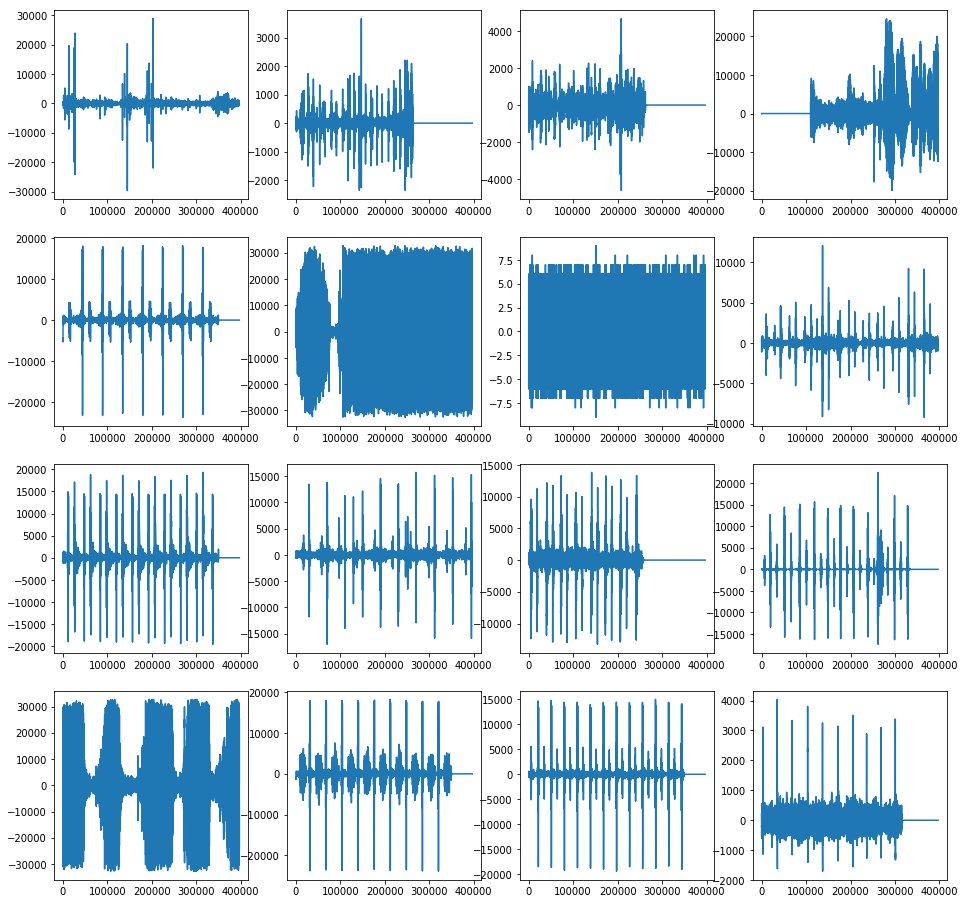

In [14]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(4, 4, figsize = (16, 16))
for i in range(len(X)):
    ax[i//4, i%4].plot(X[i])

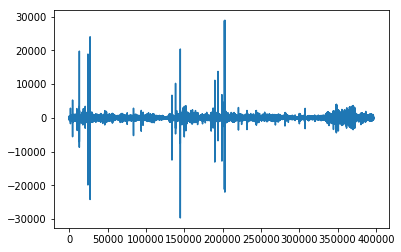

In [15]:
plt.plot(X[0])

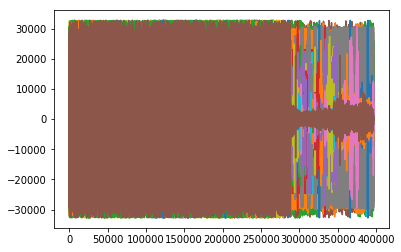

In [16]:
for i in range(len(X)):
    plt.plot(X[i])

Se elige solo una fracción de los datos para ser usados de entrenamiento: Nuestro nuevo conjunto de muestras es un conjunto de 176 datos del mismo largo (396900). Por la dimensión de los parametros, que es  varias veces mayor a nuestra cantidad de datos, existe un alto riesgo en caer en un overfiting. Se puede notar que a los arreglos que se les hizo padding, tienen una cola con valores 0, ejemplo de esto es el primer arreglo.

> f) Para pre-procesar la secuencia en el tiempo realice una transformada de fourier discreta [[5]](#refs) para pasar los datos desde el dominio de tiempos al dominio de frecuencias presentes en la señal de sonido. Visualice el cambio de representación.

In [17]:
X_fourier = np.abs(np.fft.fft(X))
X_fourier.shape

(176, 396900)

IndexError: index 4 is out of bounds for axis 0 with size 4

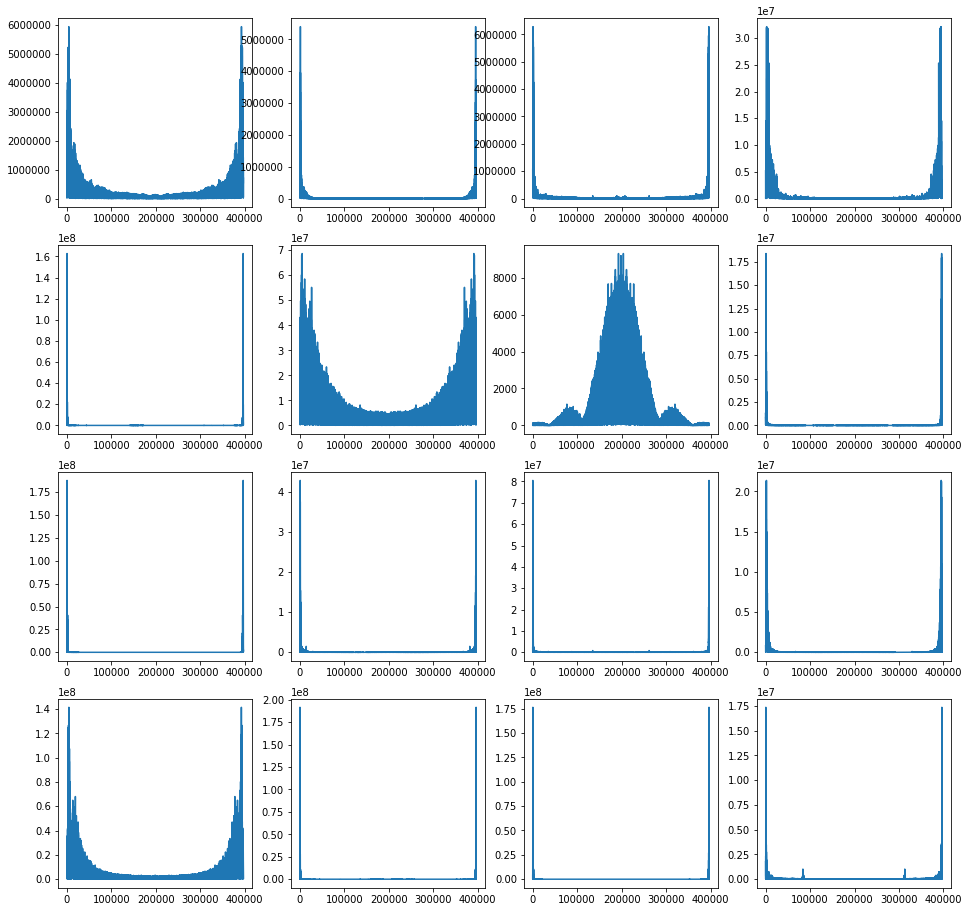

In [28]:
fig, ax = plt.subplots(4, 4, figsize = (16, 16))
for i in range(len(X_fourier)):
    ax[i//4, i%4].plot(X_fourier[i])
    

IndexError: index 2 is out of bounds for axis 0 with size 2

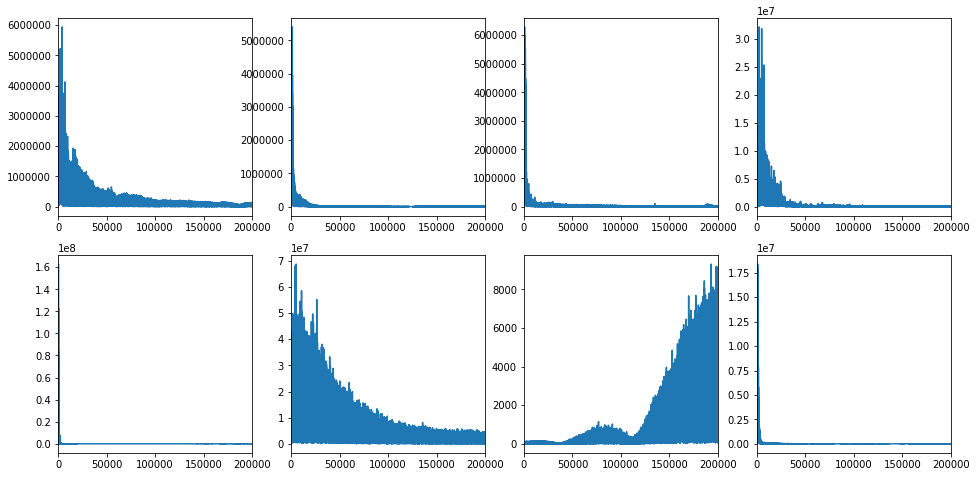

In [32]:
fig, ax = plt.subplots(2, 4, figsize = (16, 8))
for i in range(len(X_fourier)):
    ax[i//4, i%4].plot(X_fourier[i])
    ax[i//4, i%4].set_xlim([0,200000])

La transformada de fourier como bien se dijo, pasa el dominio de los datos a su dominio de frecuencias, esto nos permite estudiar el problema desde una perspectiva distinta, esto es relevante si es que se encuentra alguna relación entre la frecuencia de amplitud. La simetría se debe a que la curva transformada por fourier entrega valores reales.

Si se usara la métrica lasso se podrían descartar ciertos intervalos de frecuencia que no aportan información a la solución y así reducir el costo de procesamiento.



> g) Para seguir con el pre-procesamiento realice un muestreo representativo de los datos a través de una técnica de muestreo especializada en secuencias ¿En qué beneficia este paso? ¿Cómo podrı́a determinar si el muestro es representativo?

In [23]:
from scipy import signal
X_resampled = []
for i in range(X_fourier.shape[0]):
    sequence = X_fourier[i,:].copy()
    resampled_sequence = signal.resample(sequence, 100000)
    X_resampled.append(resampled_sequence)
X_resampled = np.array(X_resampled)
X_resampled.shape

#¿que pasa con los datos si cambia el dominio, es decir, ahora que son 10000, que es de las frecuencias?
#no se que hace esta técnica de muestreo, ni que se gana.
#continuidad en los valores


(176, 100000)

IndexError: index 4 is out of bounds for axis 0 with size 4

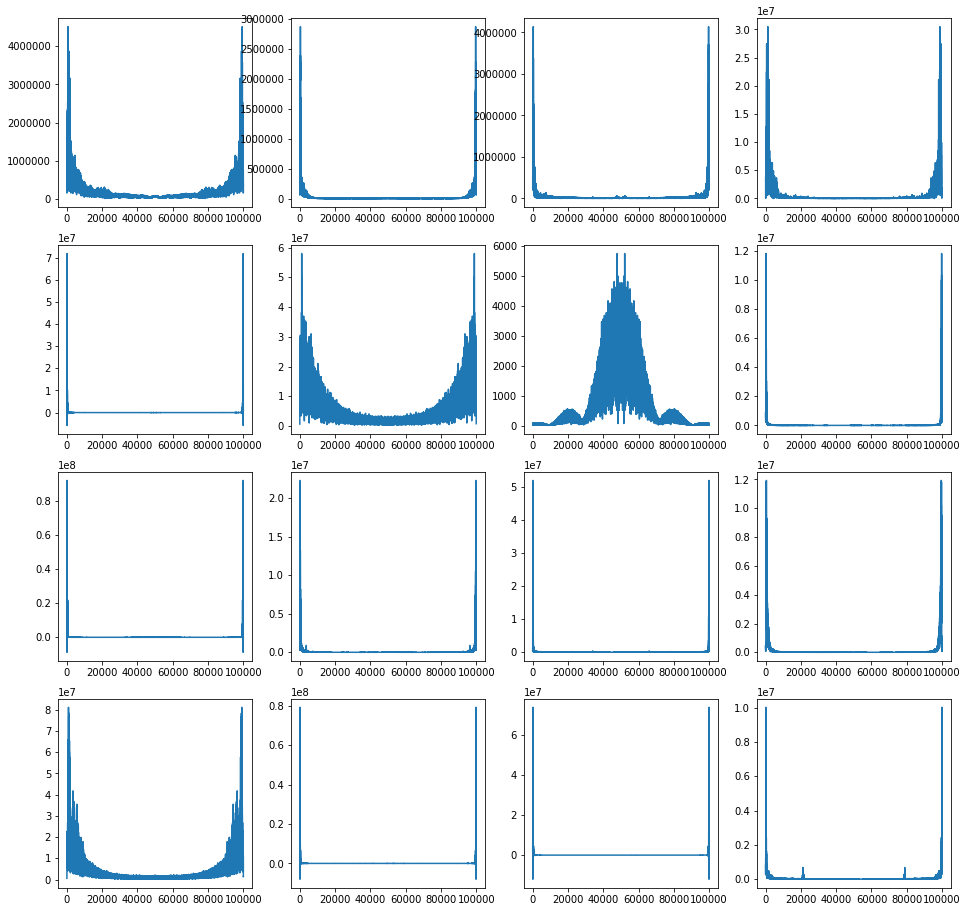

In [24]:
fig, ax = plt.subplots(4, 4, figsize = (16, 16))
for i in range(len(X_resampled)):
    ax[i//4, i%4].plot(X_resampled[i])

El comando signal.resample() toma una muestra del total de los datos, agrupandolos en 100000 intervalos. Finalmente agregando cada dato como una lista de paramentro al conjunto de muestras procesadas.

Un muestreo representativo no se puede determinar a priori sin conocimiento de la forma de los datos, en caso de ser así, un muestreo representativo reflejaría la frecuencia de un suceso y distintos atributos de cada categoría. 

> h) Debido a que no hay conjunto de pruebas, y que es necesario para evaluar la calidad **final** del modelo, genérelo a través de la técnica *hold-out*

In [35]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y, test_size=0.25, random_state=42)

Separamos nuestro conjunto de datos en los que van a ser usados para el entrenamiento del programa y aquellos que van a ser usados para validación. 1/4 de los datos se van a excluir del entrenamiento para solo ser usados en la validación.

> i) Realice un proceso de estándarizar los datos para ser trabajados adecuadamente. Recuerde que solo se debe ajustar (calcular media y desviación estándar) con el conjunto de entrenamiento.

In [55]:
from sklearn.preprocessing import StandardScaler
std = StandardScaler(with_mean=True, with_std=True)
std.fit(X_train)
X_train = std.transform(X_train)
X_test = std.transform(X_test)
print ('media=' ,np.mean(X_train),' y desviación estandar=', np.var(X_train))
X_train

media= -7.286292781249027e-17  y desviación estandar= 0.9999999999999994


array([[-0.37678166, -0.18814734, -0.59327913, ..., -0.15302993,
        -0.59327913, -0.18814734],
       [-0.37532686, -0.35151005, -0.54683709, ..., -0.32847914,
        -0.54683709, -0.35151005],
       [-0.69492173, -0.60050962, -0.82231141, ..., -0.71562595,
        -0.82231141, -0.60050962],
       ...,
       [ 0.46202566,  1.50391733,  0.29627953, ...,  0.97768843,
         0.29627953,  1.50391733],
       [ 6.94047172,  5.68976606,  0.21412084, ...,  4.3681258 ,
         0.21412084,  5.68976606],
       [ 1.33207983, -0.22532416,  0.46883265, ..., -0.33179841,
         0.46883265, -0.22532416]])

Como comentario es importante que el comando .fit no se aplique sobre los dos conjuntos (test y train) de ocurrir esto, si filtra información desde el conjunto de validación al conjunto de entrenamiento. Finalmente el comando .transform toma el arreglo y transforma sus datos a un arreglo con media 0 y varianza 1

> j) Realice una reducción de dimensionalidad a través de la técnica **PCA**, para representar los datos en $d = 2$ dimensiones. Recuerde que solo se debe ajustar (encontrar las componentes principales) con el conjunto de entrenamiento. Visualice apropiadamente la proyección en 2 dimensiones.

In [54]:
from sklearn.decomposition import PCA
d=2
pca_model = PCA(n_components=d)
pca_model.fit(X_train)
X_pca_train = pca_model.transform(X_train)
X_pca_test = pca_model.transform(X_test)
print (X_pca_train.shape)
X_pca_test.shape
print (X_pca_train)

(132, 2)
[[-4.49768867e+01 -1.50249699e+01]
 [-6.53247145e+01  8.51071797e+00]
 [-6.56417243e+01  2.62994795e+00]
 [-6.66817541e+01  1.00636164e+00]
 [-7.19243600e+01  8.04788458e+00]
 [-7.17405260e+01  8.91468730e+00]
 [-7.16895852e+01  8.76608368e+00]
 [-5.17038943e+01  1.37055438e+01]
 [-7.14990040e+01  7.67566646e+00]
 [-7.12076381e+01  7.65091138e+00]
 [-7.20449048e+01  8.61596044e+00]
 [-7.02106358e+01  6.86254064e+00]
 [-7.19725774e+01  8.45970228e+00]
 [-6.80249557e+01  5.93908866e+00]
 [-6.04719766e+01 -5.54173907e+00]
 [-6.89229058e+01  8.61426403e+00]
 [-7.23293320e+01  8.77702113e+00]
 [-7.15543583e+01  7.88789786e+00]
 [-5.37034864e+01  1.30691691e+01]
 [-7.20725580e+01  8.79728184e+00]
 [-6.59130246e+01 -8.70402659e-01]
 [-7.32227687e+01  9.68427956e+00]
 [-7.18332042e+01  8.13730975e+00]
 [-3.14069153e+00 -1.74825281e+01]
 [-7.07652743e+01  8.14794910e+00]
 [-6.88802431e+01  6.73852764e+00]
 [-7.15138541e+01  7.83313986e+00]
 [-7.01748401e+01  4.84402522e+00]
 [-5.603093

La reducción de dimensionalidad mediante la técnica PCa (principal component analysis) a continuación realizaremos una visaulización de los datos ahora que fueron proyectado a un nuevo espacio en 2D.

In [46]:
fig, ax = plt.figure(figsize = (8,8))
for i in range(len(X_pca_train)):
    ax[i//4, i%4].plot(X_pca_train[i])
    
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)

TypeError: 'Figure' object is not iterable

<Figure size 576x576 with 0 Axes>

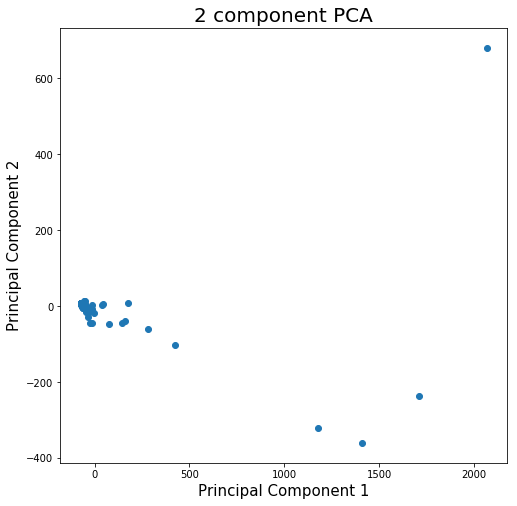

array([ -44.97688672,  -65.32471455,  -65.64172432,  -66.68175409,
        -71.92435998,  -71.74052605,  -71.6895852 ,  -51.70389434,
        -71.49900401,  -71.2076381 ,  -72.04490481,  -70.21063577,
        -71.97257737,  -68.02495573,  -60.47197658,  -68.92290583,
        -72.32933198,  -71.55435832,  -53.70348639,  -72.07255796,
        -65.91302462,  -73.22276873,  -71.83320421,   -3.14069153,
        -70.76527433,  -68.88024313,  -71.51385408,  -70.17484015,
        -56.03093265,  -58.12375515,  -70.83814816,  -69.05773116,
        -15.42291966,  -72.58022642,  -69.31632509,  -69.49701178,
        -35.91052415,   45.44061184,  -71.26303165,   75.83181611,
        -71.43696653,  -69.75361738,  -53.1947492 ,  -57.71093447,
        -71.5959237 ,  -71.73608552,  -65.82351085,  -70.5825791 ,
        -72.25257718,  -50.16706544,  -72.86557261,  -68.16123099,
        -15.81144568,  425.86755557,  -72.16004967,  -70.36794105,
        -31.48300601,  -69.38632302,  -61.5629309 ,  -63.50189

In [51]:

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)



x = X_pca_train[:,0]
y = X_pca_train[:,1]
ax.scatter(x, y)
plt.show()



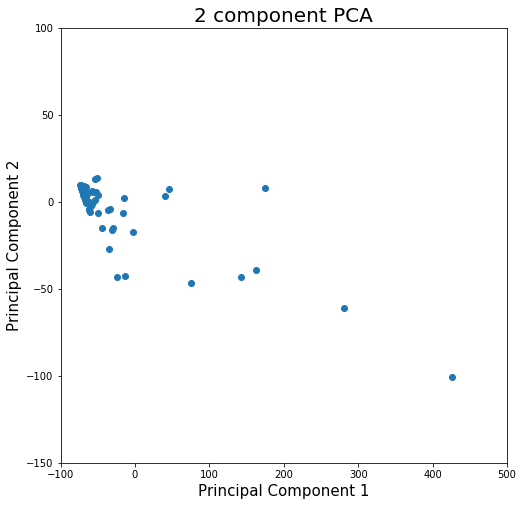

In [53]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
ax.set_xlim([-100,500])
ax.set_ylim([-150,100])


x = X_pca_train[:,0]
y = X_pca_train[:,1]
ax.scatter(x, y)
plt.show()


In [ ]:
Podemos ver que existen valores anómalos, en particular 4, se deben revisar es posible que representen errores de medición.

> k) Entrene un modelo de Regresión Logı́stica variando el parámetro de regularización $C$ construyendo un gráfico resumen del error en función de este hiper-parámetro. Además entrene un Perceptrón, variando el hiper-parámetro de regularización $\alpha$ en el rango inverso que para la Regresión Logı́stica ¿Por qué? Contruya el mismo gráfico resumen, en función de $C$ o $\alpha$. Compare y comente lo observado.

In [62]:
Cs = [0.0001,0.001,0.01,0.1,1,10,100,1000,10000]
alphas = [1/c for c in Cs]
from sklearn.linear_model import Perceptron,LogisticRegression
for c in Cs:
    model = LogisticRegression(penalty='l2', C=c,max_iter=200)
for a in alphas:
    model = Perceptron(penalty='l2', alpha=a, max_iter=200)
model

Perceptron(alpha=0.0001, class_weight=None, eta0=1.0, fit_intercept=True,
      max_iter=200, n_iter=None, n_jobs=1, penalty='l2', random_state=0,
      shuffle=True, tol=None, verbose=0, warm_start=False)

> l) Genere otra representación de los datos a través de la técnica de reducción de dimensionalidad **ICA**, con dimensionalidad $d = 2$. Recuerde que sólo se debe ajustar con el conjunto de entrenamiento, si se muestra un *warning* explique el porqué. Visualice apropiadamente la proyección en 2 dimensiones. Vuelva a realizar el item k) pero para esta nueva representación.

In [61]:
from sklearn.decomposition import FastICA
ica_model = FastICA(n_components=d)
ica_model.fit(X_train)
X_ica_train = ica_model.transform(X_train)
X_ica_test = ica_model.transform(X_test)

> m) Experimente con diferentes dimensiones $d$ para la proyección de PCA e ICA con el propósito de obtener un modelo con menor error. Construya una tabla o gráfico resumen de los errores o *accuracy*, comente.


> n) Realice otra reducción de dimensionalidad ahora a través de la técnica **LDA**, para representar los datos en $d = 2$ dimensiones. Recuerde que sólo se debe ajustar con el conjunto de entrenamiento, si se muestra un *warning* explique el porqué. Visualice apropiadamente la proyección en 2 dimensiones.

In [81]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
lda_model = LDA(n_components=2)
lda_model.fit(X_train,y_train)
X_lda_train = lda_model.transform(X_train)
X_lda_test = lda_model.transform(X_test)

C:\Users\rosar\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


> o) Con el propósito de encontrar el mejor modelo vuelva a realizar el item k) en el nuevo espacio generado por la representación según las $d$ dimensiones de la proyección LDA. Esta nueva representación ¿mejora o empeora el desempeño? Explique.

> p) Intente mejorar el desempeño de los algoritmos ya entrenados. Diseñe ahora sus propias cracterı́sticas (*feature crafting*) a partir de los datos brutos (secuencia de amplitudes), puede inspirarse en otros trabajos [[6]](#refs), [[7]](#refs)  si desea.